In [37]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

## Image compression via SVD

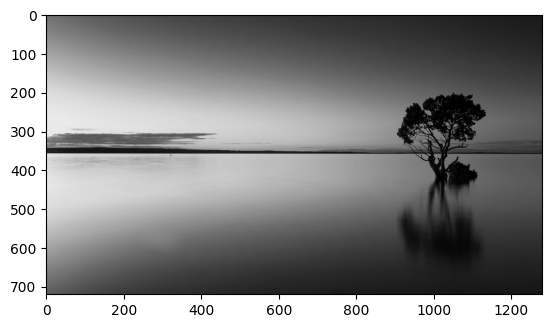

In [11]:
img = Image.open("data/sunset.jpg")

# Convert to grayscale so we don't have to deal with the complexity of multiple
# color channels
img = img.convert('LA')
plt.imshow(img)

# Covnert into numpy matrix
img_mat = np.array(list(img.getdata(band=0)), float)
img_mat.shape = (img.size[1], img.size[0])
img_mat = np.matrix(img_mat)

In [13]:
# Calculate SVD of image
U, sigma, V = torch.linalg.svd(torch.Tensor(img_mat))

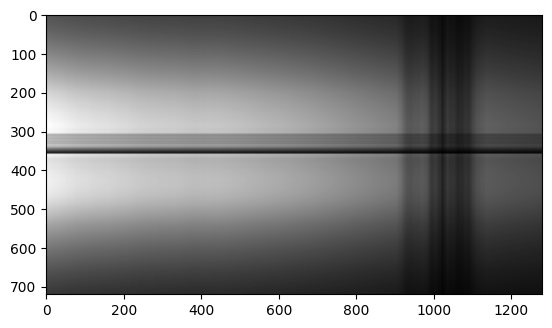

In [14]:
# As eigenvalues are arranged in descending order in diag(sigma) so to are singular
# values, by convention, arranged in descending order in D. Thus, the first
# left-singular vector of U and first right-singular vector of V may represent the
# most prominent feature of the image.
reconstructed_img = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstructed_img, cmap="gray")

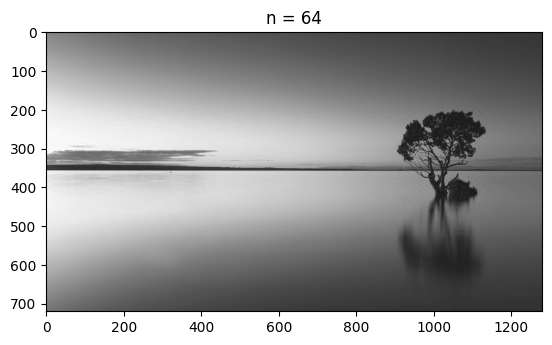

In [18]:
# Additional singular vectors improve the image quality
for i in [2, 4, 8, 16, 32, 64]:
    reconstructed = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstructed, cmap="gray")
    plt.title(f"n = {i}")

In [28]:
# With 64 singular vectors, the image is very well reconstructed, but the data
# footprint is much smaller than the original image
print(f"Original shape => {img_mat.shape}")

full_size_representation = np.prod(img_mat.shape)
print(f"Original full size => {full_size_representation}")

svd_64_rep_full_size = 64*img_mat.shape[0] + 64 + 64*img_mat.shape[1]
print(f"Reconstructed image full size (64 steps) => {svd_64_rep_full_size}")

print(f"Compression result => {round((svd_64_rep_full_size/full_size_representation) * 100, 2)}%")

Original shape => (720, 1280)
Original full size => 921600
Reconstructed image full size (64 steps) => 128064
Compression result => 13.9%


## Principal Component Analysis (PCA)

In [35]:
iris = datasets.load_iris()
print(iris.data.shape)
print(iris.get("feature_names"))

(150, 4)

(150, 2)


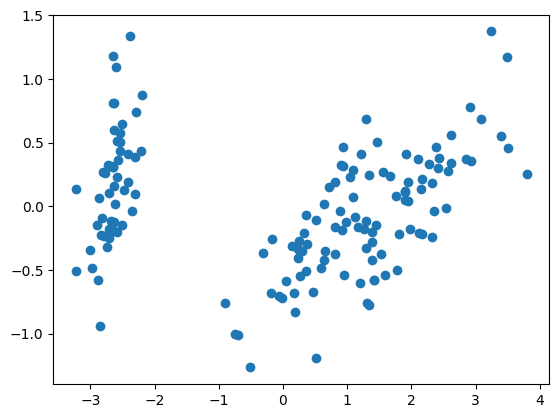

In [41]:
# two components to plot X,Y
pca = PCA(n_components=2)

X = pca.fit_transform(iris.data)
print(X.shape)

plt.scatter(X[:, 0], X[:, 1])

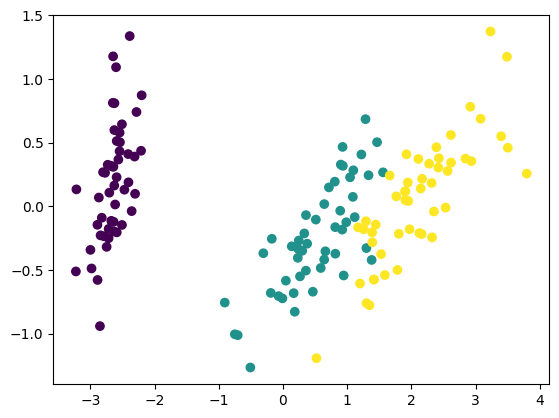

: 

In [42]:
# As we actually do have labels, we can classify the data
plt.scatter(X[:, 0], X[:, 1], c=iris.target)